In [1]:
%load_ext autoreload
%autoreload 2

In [140]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable

# %run style_sheet_MH.ipynb
plt.style.reload_library()
plt.style.use('EuroSAFs_pub')

In [3]:
sys.path.insert(1,'../../scripts/optimization/')

In [4]:
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../data/Countries_WGS84/processed/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../data/Countries_WGS84/processed/Europe_WGS84.shp')

In [6]:
EU_EFTA = europe_grid.country.unique()

In [21]:
results_path = os.path.join('../../results/plant_optimization/final_results') # Points to the location of the results csv files


# Import Plant Assumptions

In [8]:
specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

# Import Land Cover Data

In [32]:
countries = europe_grid.country.unique()
lc_path = '../../results/land_availability/scenario_01'
lc_data = pd.DataFrame()
for country in countries:
    lc_data = lc_data.append(pd.read_csv(f'{lc_path}/{country}_land_availability.csv',index_col=0))
lc_data.rename(columns={'name':'country'},inplace=True)
# Correct an error in which the Norway points are given NaN for the country name
lc_data.loc[lc_data.country.isna(),'country'] = 'Norway'
lc_data.crs = gpd.GeoDataFrame(lc_data,crs=europe_grid.crs)

/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  if __name__ == '__main__':
/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [29]:
type(lc_data)

pandas.core.frame.DataFrame

In [30]:
lc_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Import LCOF Results

In [47]:
# countries = ['Switzerland','Austria','Germany','France','Italy']
countries = europe_grid.country.unique()
# countries = ['France']
results = pd.read_csv(os.path.join(results_path,'2020.csv'))
results.drop(columns=['geometry'],inplace=True)
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

In [23]:
lc_data.head()

,country,lat,lon,avail_area_sqkm
0,Austria,47.0,9.375,5.977493
1,Austria,47.5,9.375,0.000000
2,Austria,47.0,10.000,287.090600
3,Austria,47.5,10.000,30.869196
4,Austria,47.0,10.625,368.496520


<AxesSubplot:>

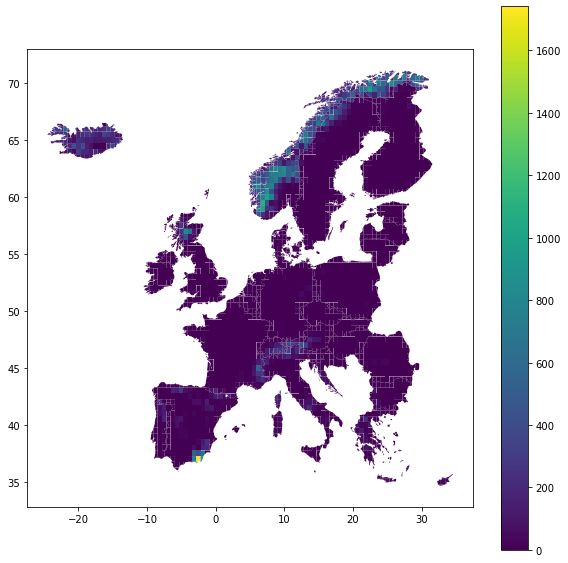

In [59]:
combined = results_gdf.loc[~results_gdf.sea_node].merge(lc_data[['country','lat','lon','avail_area_sqkm']],on=['lat','lon','country'],how='left')
combined = gpd.GeoDataFrame(combined, crs=results_gdf.crs)
combined.plot(column='avail_area_sqkm',figsize=(10,10),legend=True)

In [60]:
year = 2020
combined['turbine_area_sqkm'] = (combined.rotor_diameter*specs.at['wind_turbine_spacing',f'value_{year}'])**2*combined.wind_turbines/1e6
combined['pv_area_sqkm'] = combined.PV_capacity_MW*1e3/specs.at['PV_peak_per_area',f'value_{year}']/1e6
combined['plant_area_sqkm'] = combined['turbine_area_sqkm'] + combined['pv_area_sqkm']
combined['plants'] = combined.avail_area_sqkm/combined.plant_area_sqkm
combined['production_GWh'] = combined.plants * specs.at['required_fuel',f'value_{year}']
combined['production_liters'] = combined.production_GWh*3.6e12/specs.at['kerosene_LHV',f'value_{year}']/0.8

<AxesSubplot:>

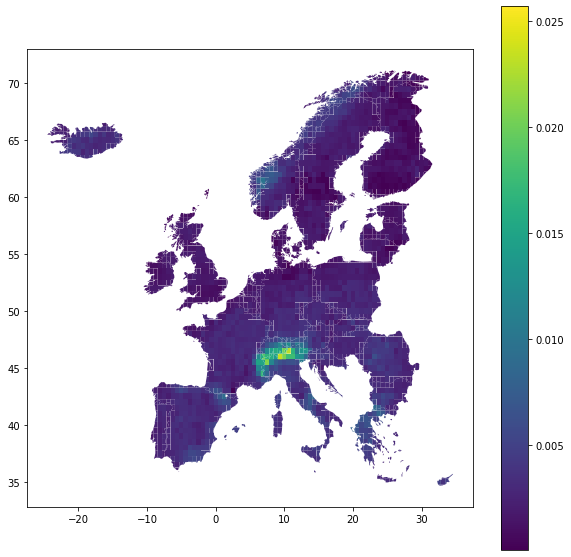

In [61]:
combined.plot(column='pv_area_sqkm',figsize=(10,10),legend=True)

<AxesSubplot:>

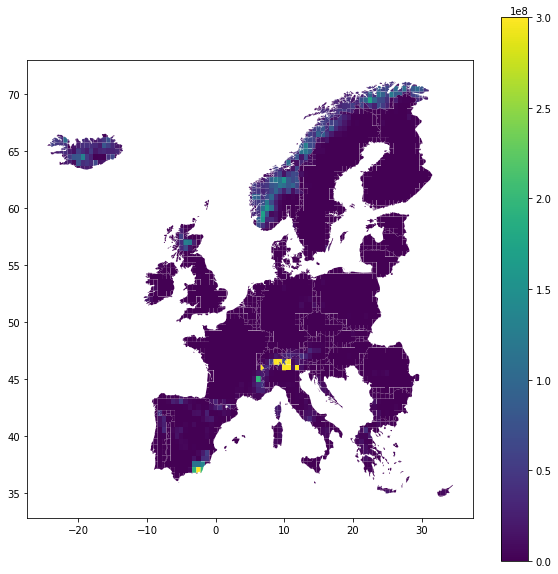

In [62]:
combined.plot(column='production_liters',figsize=(10,10),legend=True,vmax=3e8)

# Plot cost curve

IATA average jet fuel price for 2021: \$77.6/bbl [source](https://www.iata.org/en/publications/economics/fuel-monitor/)
<br> Average exchange rate 2021: 1.183 USD = 1 EUR [source](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2021.html)
<br> IATA average jet fuel price for 2019: \$79.6/bbl [source](https://iata.org.xy2401.com/publications/economics/fuel-monitor/Pages/index.aspx.html)
<br> Average exchange rate 2019: 1.1199 USD = 1 EUR [source](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2019.html)
<br> 1 US bbl oil = 158.99 L

In [101]:
exchange_rate_2019 = 1.1199 #USD to EUR
exchange_rate_2021 = 1.18 #USD to EUR
exchange_rate_2022 = 1.13 #USD to EUR
bbl_to_liter = 158.99 #US bbl oil to liters
fossil_price_2019 = 79.6/exchange_rate_2019/bbl_to_liter
fossil_price_2021 = 77.6/exchange_rate_2021/bbl_to_liter
print(fossil_price_2019,fossil_price_2021)

0.4470581470615859 0.41362797574946086


In [169]:
# TEMPORARY FILTER ON LCOF
max_lcof = 5
cost_curve = combined.loc[combined.LCOF_liter<=max_lcof].sort_values('LCOF_liter').reset_index()

# cost_curve = cost_curve.loc[cost_curve.plants<=100].reset_index()
# cost_curve = combined.sort_values('LCOF_liter').reset_index()
cost_curve['production_liters_cumsum'] = cost_curve.production_liters.cumsum()

In [94]:
combined.plants.describe()

count     3102.000000
mean        34.235035
std        596.734663
min          0.000000
25%          0.000000
50%          0.000000
75%          1.338179
max      19076.224658
Name: plants, dtype: float64

In [177]:
%matplotlib inline

In [183]:
plt.style.reload_library()
plt.style.use('EuroSAFs_pub')

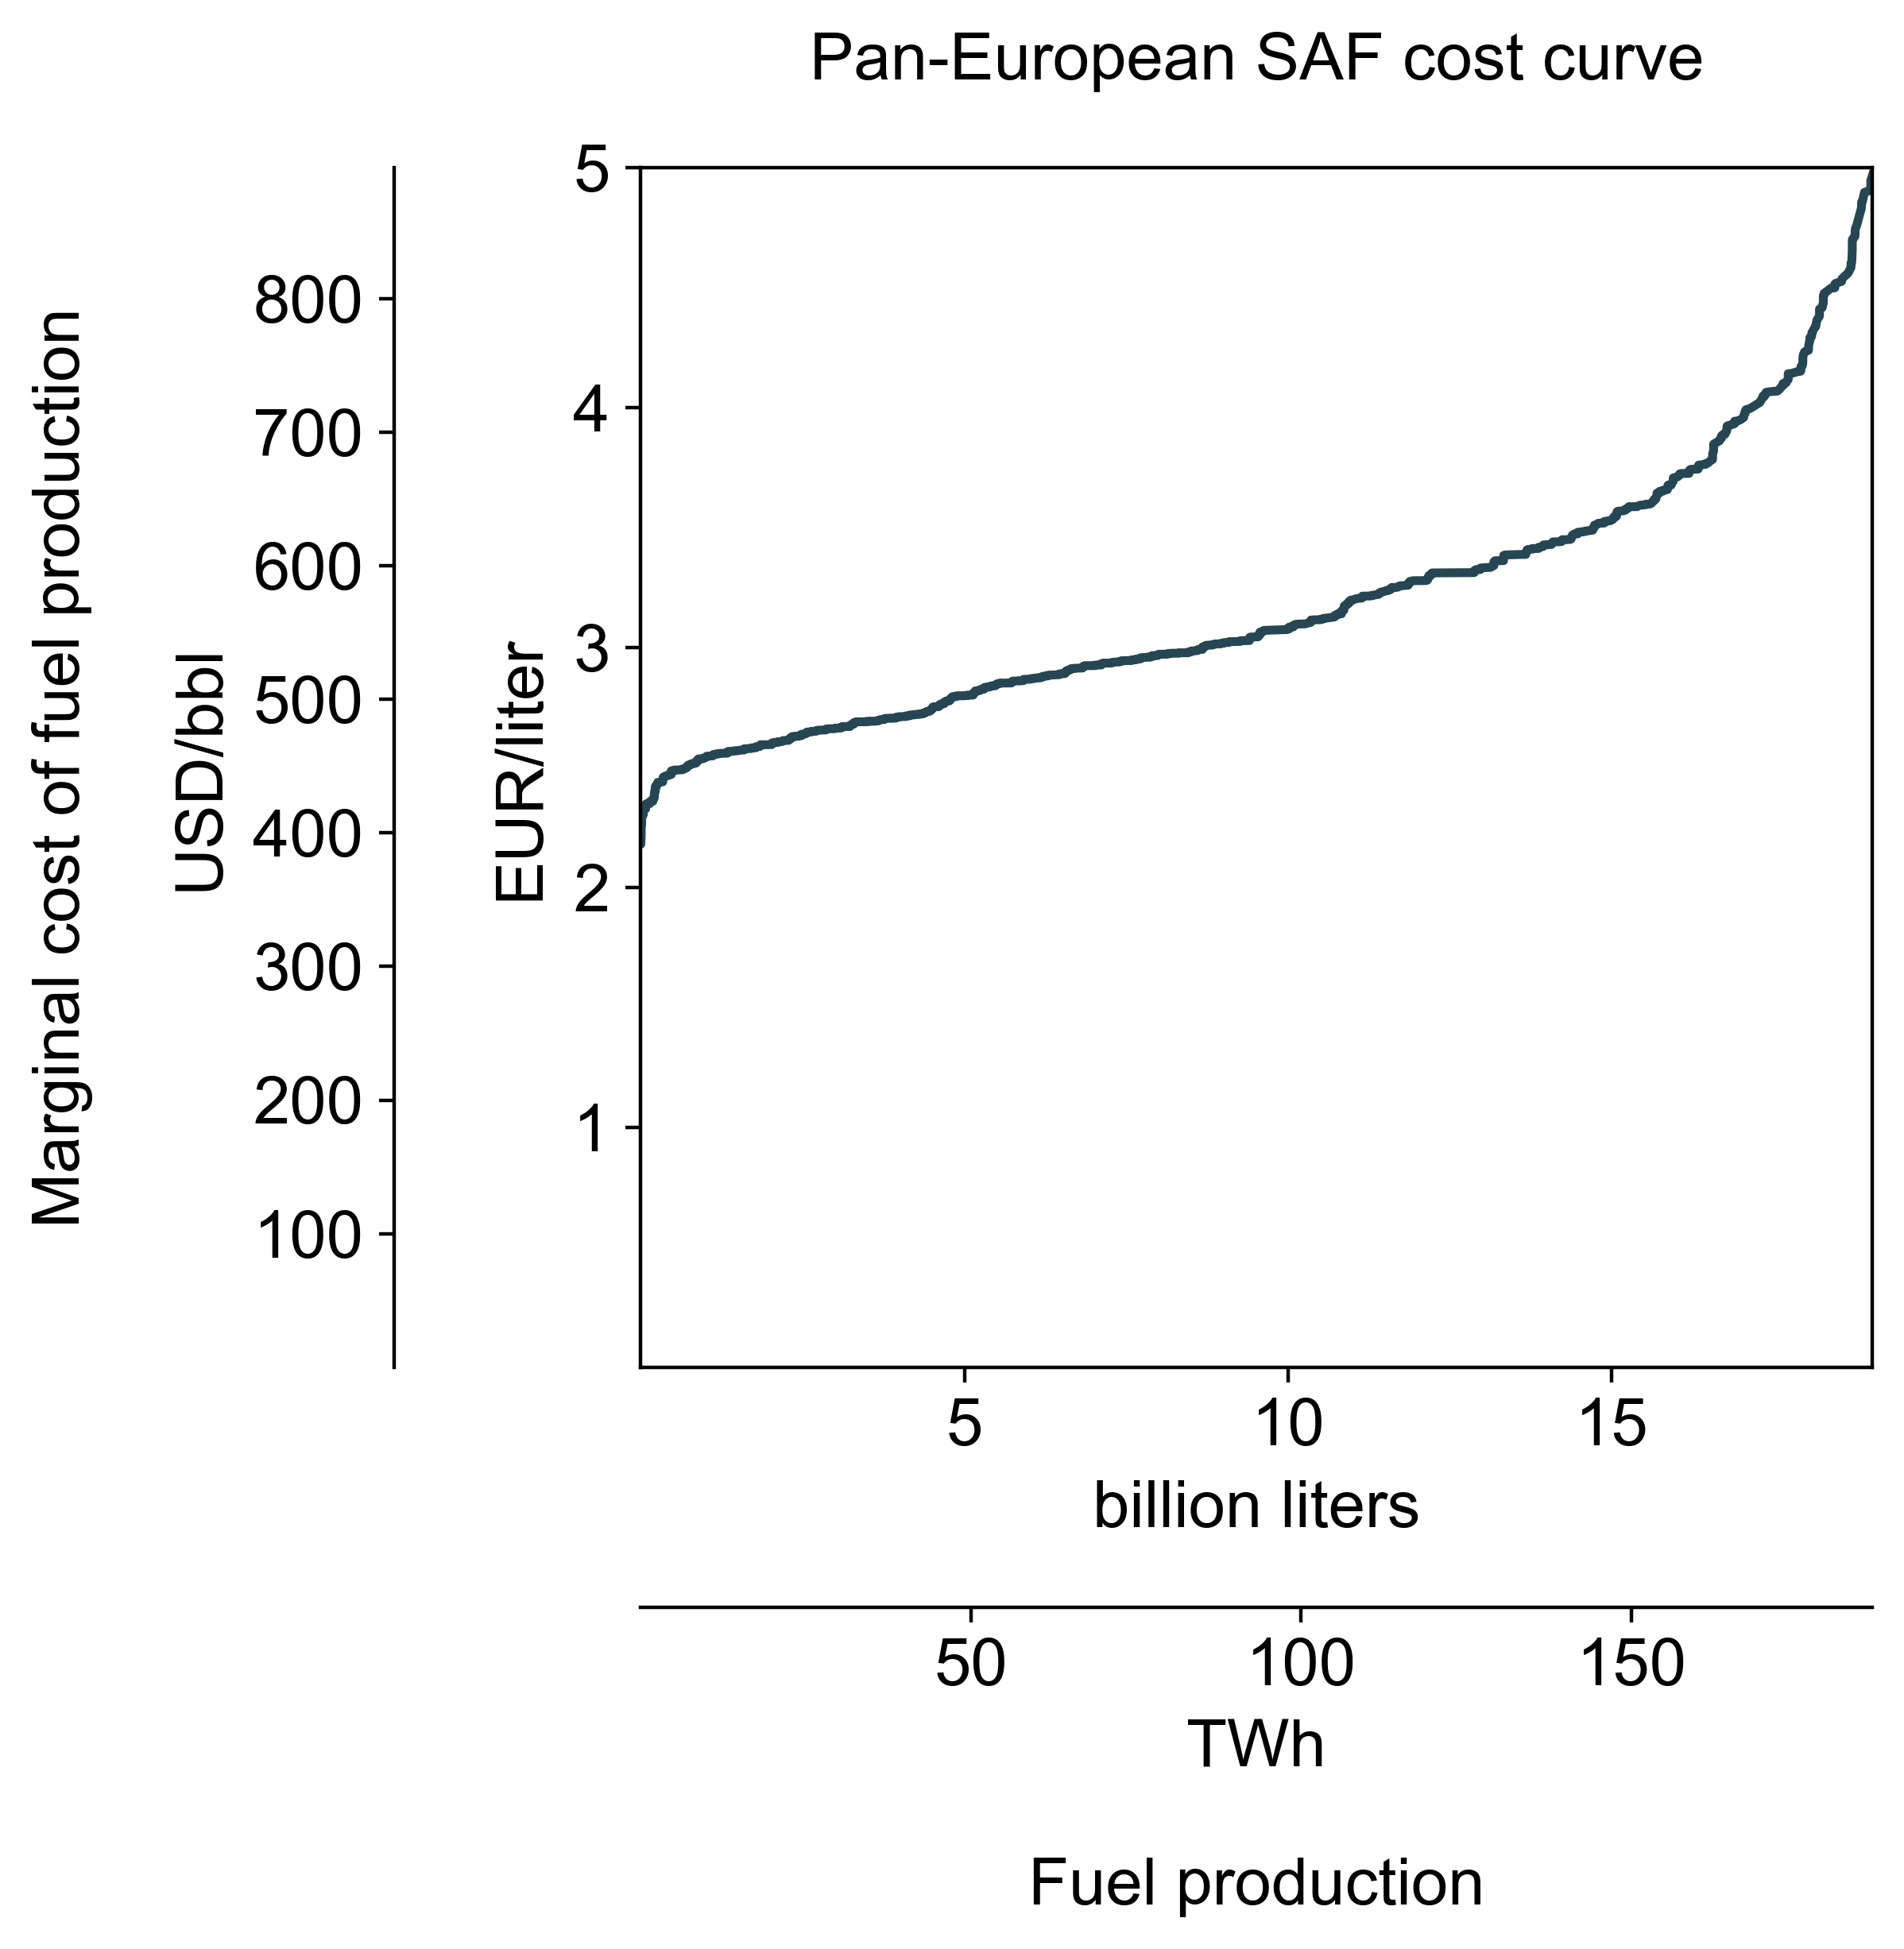

In [207]:
fig,axes = plt.subplots(figsize=(5,5))

axes.plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter)

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion liters
x_max = cost_curve.production_liters_cumsum.max()/1e9 # billion liters

axes.set_ylim(y_min,y_max)
axes.set_ylabel('EUR/liter', labelpad=5)
# yax2 = plt.twinx(axes)
# yax2.set_ylim(y_min*exchange_rate_2022*bbl_to_liter,y_max*exchange_rate_2022*bbl_to_liter)
yax2 = axes.secondary_yaxis(-0.2, functions=(lambda y: y*exchange_rate_2022*bbl_to_liter, lambda y: y/exchange_rate_2022/bbl_to_liter))
yax2.set_ylabel('Marginal cost of fuel production\n\nUSD/bbl', labelpad=5)

axes.set_xlim(x_min,x_max)
axes.set_xlabel('billion liters', labelpad=5)

# xax2 = plt.twiny(axes)
# xax2.set_xlim(x_min*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6,x_max*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6) # 0.8 kg/L  |  3.6e15 TWh/J
xax2 = axes.secondary_xaxis(-0.2, functions=(lambda x: x*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6, lambda x: x/0.8/specs.at['kerosene_LHV','value_2020']*3.6e6))

xax2.set_xlabel('TWh\n\nFuel production', labelpad=5)

axes.set_title('Pan-European SAF cost curve');
plt.savefig('../../gfx/pan-european_cost_curve.png', bbox_inches='tight')

EU Fuel consumption 2019 ([source](https://www.eia.gov/opendata/qb.php?category=2135044&sdid=INTL.63-2-EU27-TJ.A))

In [171]:
2233420.6338943 * 0.000277778

620.395116841891